TODO: intro, mention using bigquery and TF2.0 and TFP

In [1]:
# Install packages
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

ERROR: spyder 3.3.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 3.3.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: gym 0.13.1 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.


In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex

from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.math import random_rademacher
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
from tensorflow.keras.optimizers import Adam

from catboost import CatBoostRegressor

from google.cloud import bigquery

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(12345)
tf.random.set_seed(12345)

## Data

TODO: explain, more eda in previous post

In [3]:
%%time

# SQL Query to retreive the data
# There are 131M records in full dataset!
QUERY = """
    SELECT
        pickup_datetime,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        fare_amount
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    LIMIT 5000000;
"""

# Load a subset of the dataset
data = bigquery.Client().query(QUERY).to_dataframe()

Using Kaggle's public dataset BigQuery integration.
CPU times: user 2min 17s, sys: 9.22 s, total: 2min 27s
Wall time: 7min 44s


In [4]:
# Drop rows with empty values
data.dropna(inplace=True)

# Extract useful time information
data['min_of_day'] = (60*data['pickup_datetime'].dt.hour + 
                       data['pickup_datetime'].dt.minute)
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear

# Remove original datetime column
data.drop('pickup_datetime', axis=1, inplace=True)

# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove outliers
data = clip(data, 1, 200, ['fare_amount'])
data = clip(data,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
data = clip(data, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

# Transform target column
data['fare_amount'] = np.log(np.log10(data['fare_amount']))

# Normalize data
data = (data - data.mean()) / data.std()

# Cast down to float32
data = data.astype('float32')

# Shuffle
data = data.sample(frac=1)

# Separate in- from dependent variables
x_taxi = data.drop('fare_amount', axis=1)
y_taxi = data['fare_amount']

TODO: print head and simple plots

In [5]:
x_taxi.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year
69641,-0.120128,1.258599,-0.129485,1.219487,-0.296647,-1.044278,0.088852
1546336,-0.653723,-0.624488,-0.255578,-0.613423,-0.704657,0.486506,0.011339
2110539,-0.494860,-0.122331,-0.174720,-0.085391,-0.079565,-1.554539,1.290305
1439737,-0.744369,-0.530258,-0.857449,-0.626182,0.943076,0.996767,-1.190114
1617162,0.022615,0.152416,-0.175891,0.052840,-0.100488,-0.534017,-0.298714


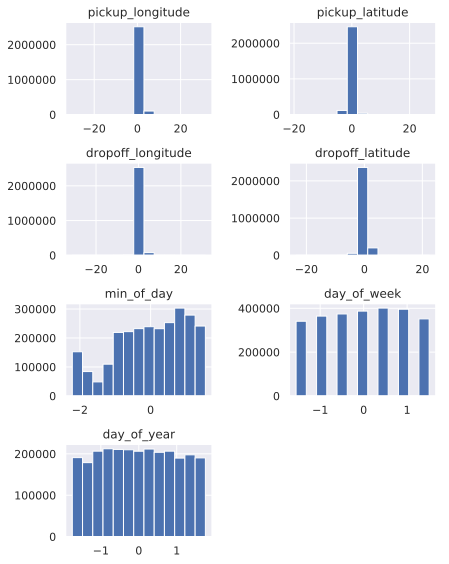

In [6]:
plt.figure(figsize=(6.4, 8))
for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.hist(x_taxi.iloc[:, i], 13)
    plt.title(x_taxi.columns[i])
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Normalized Fare')

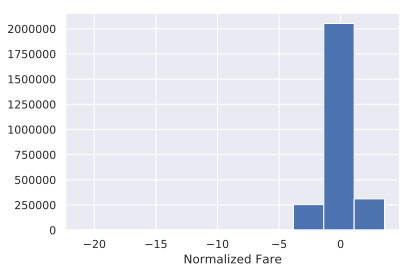

In [7]:
plt.hist(y_taxi)
plt.xlabel('Normalized Fare')

## Baseline Models

In [8]:
# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

In [9]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 0.7694996198018392


In [10]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 0.36070719361305237


TODO: let's also see how a gradient-boosted decision tree does.

In [11]:
%%time

# MAE using CatBoost
cv_mae(CatBoostRegressor(verbose=False, depth=9), x_taxi, y_taxi)

MAE: 0.2884315375635771
CPU times: user 42min 48s, sys: 4min 17s, total: 47min 5s
Wall time: 26min 2s


## Vanilla Neural Network

TODO: first will try just a normal neural net, but first need to set some settings which we'll use for the training of all neural nets (bayesian and non-bayesian)

In [12]:
# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 150

# Learning rate
L_RATE = 1e-4

# Proportion of samples to hold out
VAL_SPLIT = 0.2

TODO: then build a normal neural net 

TODO: diagram

In [13]:
# Multilayer dense neural network
D = x_taxi.shape[1]
model = Sequential([
    Dense(512, use_bias=False, input_shape=(D,)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(128, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(64, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(32, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(1)
])

In [14]:
# Compile the model with MAE loss
model.compile(tf.keras.optimizers.Adam(lr=L_RATE),
              loss='mean_absolute_error')

In [15]:
%%time

# Fit the model
history = model.fit(x_taxi, y_taxi,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VAL_SPLIT,
                    verbose=0)

CPU times: user 43min 25s, sys: 4min 28s, total: 47min 53s
Wall time: 35min 41s


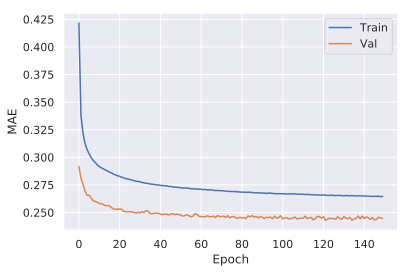

In [16]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

TODO: note that val loss is less than train loss, this is bc of the dropout

## Simple Bayesian Neural Network

TODO: were gonna use TFP DenseFlipout layer but it doesn't fully support TF2.0 eager execution yet!  ie the kl loss was getting reset each batch


In [17]:
# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

TODO: xavier initializer to initialize the weights (link etc)

In [18]:
# Xavier initializer
def xavier(shape):
    return tf.random.truncated_normal(
        shape, 
        mean=0.0,
        stddev=np.sqrt(2/sum(shape)))

TODO: simple version of a bayesian dense neural network layer. Takes one sample from the variational distributions per batch

In [19]:
class BayesianDenseLayer(tf.keras.Model):
    """TODO docs"""

    def __init__(self, d_in, d_out, name=None):
        super(BayesianDenseLayer, self).__init__(name=name)
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
        
    
    @property
    def weight(self):
        return tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
    
    
    @property
    def bias(self):
        return tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        
        
    def call(self, x, sampling=True):
        if sampling:
            return x @ self.weight.sample() + self.bias.sample()        
        else:
            return x @ self.w_loc + self.b_loc
            
            
    @property
    def losses(self):
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))

TODO: problems w/ using only a single sample per batch.  Flipout and how that helps reduce variance of gradient estimates.  So will make a dense layer which uses flipout:

In [20]:
class BayesianDenseLayer(tf.keras.Model):
    """TODO docs"""

    def __init__(self, d_in, d_out, name=None):
        
        super(BayesianDenseLayer, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
    
    
    def call(self, x, sampling=True):
        """TODO docs"""
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = random_rademacher(tf.shape(x))
            r = random_rademacher([x.shape[0], self.d_out])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = random_rademacher([x.shape[0], self.d_out])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        """TODO docs"""
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))

TODO: then we can create a model which uses those dense layers to easily create multilayer dense bayesian networks:

In [21]:
class BayesianDenseNetwork(tf.keras.Model):
    """TODO docs"""
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        """TODO docs"""

        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        """TODO docs"""
        return tf.reduce_sum([s.losses for s in self.steps])

TODO: finally, we need to have a full model which we can fit. Previous module only gave us predictions of the *mean*, didn't include an observation distribution or expected error.  Will create a model which includes a standard deviation param (which we'll model w/ a sqrt inverse gamma dist).  This model will have not just a call method (which gives the means) but a log_likelihood method (which computes the log likelihood of some data given the current parameter values)

TODO: now `call` returns 2 columns: first is mean predictions and 2nd is std predictions

TODO: also have a sample method which returns samples from the predictive distribution

In [22]:
class BayesianDenseRegression(tf.keras.Model):
    """TODO docs"""
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseRegression, self).__init__(name=name)
        
        # Multilayer fully-connected neural network to predict mean
        self.loc_net = BayesianDenseNetwork(dims)
        
        # Variational distribution variables for observation error
        self.std_alpha = tf.Variable([10.0], name='std_alpha')
        self.std_beta = tf.Variable([10.0], name='std_beta')

    
    def call(self, x, sampling=True):
        """TODO docs"""
        
        # Predict means
        loc_preds = self.loc_net(x, sampling=sampling)
    
        # Predict std deviation
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        transform = lambda x: tf.sqrt(tf.math.reciprocal(x))
        N = x.shape[0]
        if sampling:
            std_preds = transform(posterior.sample([N]))
        else:
            std_preds = tf.ones([N, 1])*transform(posterior.mean())
    
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
    
    
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """TODO docs"""
                
        # Loss due to network weights
        net_loss = self.loc_net.losses

        # Loss due to std deviation parameter
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        prior = tfd.Gamma(10.0, 10.0)
        std_loss = tfd.kl_divergence(posterior, prior)

        # Return the sum of both
        return net_loss + std_loss

TODO: instantiate the model

In [23]:
model1 = BayesianDenseRegression([7, 256, 128, 64, 32, 1])
# num parameters?

TODO: same optimizer + learning rate

In [24]:
# Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

TODO: create a TF function which performs a training step on a single minibatch

TODO: mention the scaling of the KL vs log liklihood contributions to the loss, link to graves' paper.

In [25]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model1.log_likelihood(x_data, y_data)
        kl_loss = model1.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model1.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model1.trainable_variables))
    return elbo_loss

TODO: then can fit the model, and evaluate on held-out validation data each epoch (except don't use sampling from the var dists on evaluation, just use MAP estimates of the parameters)

In [26]:
%%time

# Fit the model
elbo1 = np.zeros(EPOCHS)
mae1 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo1[epoch] = train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model1(x_data, sampling=False)[:, 0]
        mae1[epoch] = mean_absolute_error(y_pred, y_data)

CPU times: user 1h 6min 21s, sys: 14min 45s, total: 1h 21min 6s
Wall time: 53min 12s


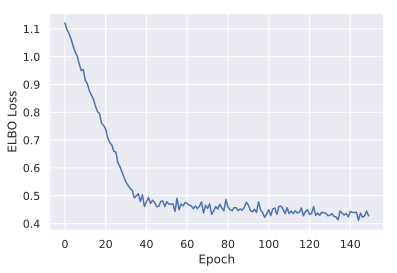

In [27]:
# Plot the ELBO loss
plt.plot(elbo1)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

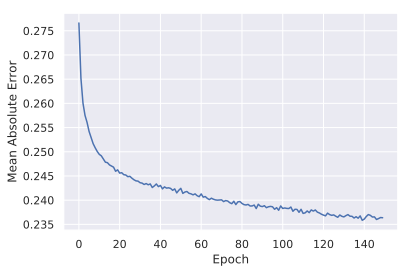

In [28]:
# Plot validation error over training
plt.plot(mae1)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

TODO: does pretty well, almost as well as the keras net!

TODO: but there's one problem with that model: it assumes a constant error (the std dev param doesn't change depending on the input data). To fix that next we'll make a network which predicts both the mean and the std dev.

## Dual-headed Bayesian Density Network

TODO: a model which uses a net w/ 2 heads, one for mean and 1 for std

TODO: diagram

In [29]:
class BayesianDensityNetwork(tf.keras.Model):
    """Multilayer fully-connected Bayesian neural network, with two
    two heads to predict both the mean and the standard deviation.
    
    Parameters
    ----------
    input_dims : int
        Number of input dimensions
    units : list of int
        Number of output dimensions for each layer.
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, units, head_units, name=None):
        
        # Initialize
        super(BayesianDensityNetwork, self).__init__(name=name)
        
        # Create sub-networks
        self.core_net = BayesianDenseNetwork(units)
        self.loc_net = BayesianDenseNetwork([units[-1]]+head_units)
        self.std_net = BayesianDenseNetwork([units[-1]]+head_units)

    
    def call(self, x, sampling=True):
        """Pass data through the model
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their variational
            distributions (if True, the default), or just use the
            Maximum a Posteriori parameter value estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor of shape (Nsamples, 2)
            Output of this model, the predictions.  First column is
            the mean predictions, and second column is the standard
            deviation predictions.
        """
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
        
        
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """The sum of the KL divergences between the priors and
        posteriors, assuming normal priors w/ mean=0 and std=1,
        for all layers.
        """
        return self.core_net.losses + self.loc_net.losses + self.std_net.losses

TODO: now can instantiate and fit the model

In [30]:
# Instantiate the model
model2 = BayesianDensityNetwork([7, 256, 128], [64, 32, 1])
# Note: [8 128 64], [32 16 1] net has 14728 weights (x2 = ~30k parameters)

TODO: we'll use the same optimizer + learning rate

In [31]:
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

In [32]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model2.log_likelihood(x_data, y_data)
        kl_loss = model2.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
    return elbo_loss

In [33]:
%%time

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo2[epoch] = train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)

CPU times: user 1h 5min 37s, sys: 7min 37s, total: 1h 13min 14s
Wall time: 59min 15s


TODO: show the loss over training (note that we wouldn't expect it to be on quite the same scale as the other model - ie if it's lower that doesn't neccesarily mean it's better - because there are a different number of parameters in this model)

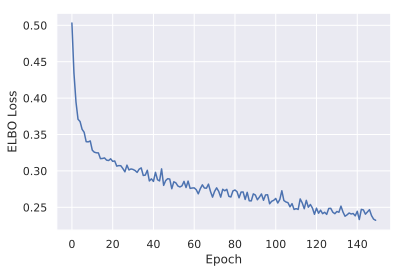

In [34]:
# Plot the ELBO Loss over training
plt.plot(elbo2)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

TODO: and the error

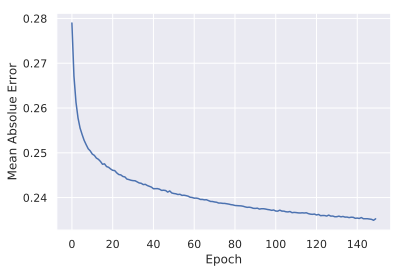

In [35]:
# Plot error over training
plt.plot(mae2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolue Error')
plt.show()

## Model Evaluation

TODO

### Learning Curves

TODO: two models do about the same in terms of their learning curves (MAE on val data):

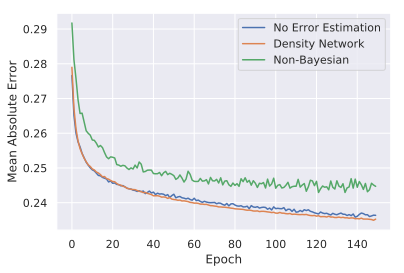

In [36]:
plt.plot(mae1, label='No Error Estimation')
plt.plot(mae2, label='Density Network')
plt.plot(history.history['val_loss'], label='Non-Bayesian')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

### Residuals

TODO

Text(0, 0.5, 'Count')

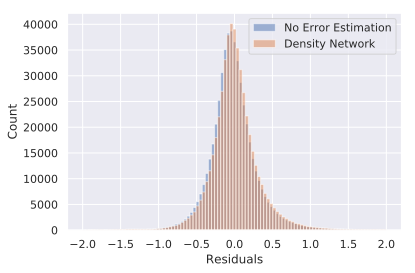

In [37]:
# Make predictions on validation data
for x_data, y_data in data_val:
    resids1 = y_data[:, 0] - model1(x_data, sampling=False)[:, 0]
    resids2 = y_data[:, 0] - model2(x_data, sampling=False)[:, 0]
    
# Plot residual distributions
bins = np.linspace(-2, 2, 100)
plt.hist(resids1.numpy(), bins, alpha=0.5,
         label='No Error Estimation')
plt.hist(resids2.numpy(), bins, alpha=0.5,
         label='Density Network')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Count')

### Predictive Distributions

TODO: draw samples from the predictive distributions (distributions which include both epistemic and alleatoric uncertainty)

In [38]:
%%time

# Sample from predictive distributions
for x_data, y_data in data_val:
    samples1 = model1.samples(x_data, 1000)
    samples2 = model2.samples(x_data, 1000)

CPU times: user 3min 3s, sys: 3min 5s, total: 6min 8s
Wall time: 6min 49s


TODO: then plot the true values vs the predictions for both networks

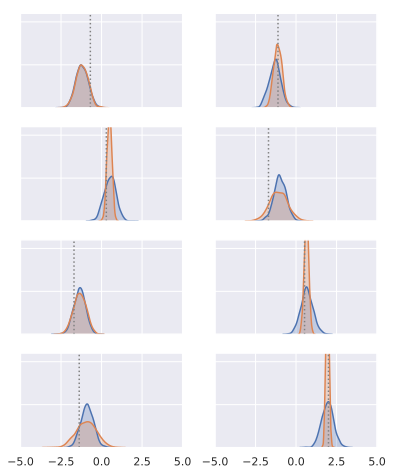

In [39]:
plt.figure(figsize=(6.4, 8))
for i in range(8):
    plt.subplot(4,2,i+1)
    sns.kdeplot(samples1[i,:], shade=True)
    sns.kdeplot(samples2[i,:], shade=True)
    plt.axvline(y_data.numpy()[i], ls=':', color='gray')
    plt.xlim([-5, 5])
    plt.ylim([0, 2.2])
    plt.gca().get_yaxis().set_ticklabels([])
    if i<6:
        plt.gca().get_xaxis().set_ticklabels([])

Notice how density network (orange) varies its uncertainty estimates, unlike the model which doesn't estimate uncertainty (blue).  For example, in the upper-left panel, the density network is much more certain of its estimate than the other model, and its predictive distribution is much sharper.  Though for other datapoints, like that in panel 5, the density network is *less* certain of its estimate, and the predictive distribution is wider.  And sometimes both models have the same uncertainty, like in the lower-right panel.

### Coverage of the 95% Confidence Interval

TODO: look at coverage of the 95% interval

In [40]:
def covered(samples, y_true, prc=95.0):
    """Whether each sample was covered by its predictive interval"""
    q0 = (100.0-prc)/2.0 #lower percentile 
    q1 = 100.0-q0        #upper percentile
    within_conf_int = np.zeros(len(y_true))
    for i in range(len(y_true)):
        p0 = np.percentile(samples[i,:], q0)
        p1 = np.percentile(samples[i,:], q1)
        if p0<=y_true[i] and p1>y_true[i]:
            within_conf_int[i] = 1
    return within_conf_int

# Compute what samples are covered by their 95% predictive intervals
covered1 = covered(samples1, y_data)
covered2 = covered(samples2, y_data)

TODO: coverage overall

In [41]:
print('No Unc Estimation: ', 100*np.mean(covered1))
print('Density Network: ', 100*np.mean(covered2))

No Unc Estimation:  96.07546375577603
Density Network:  95.5024060768988


TODO: can look at coverage  as a fn of time...

In [42]:
# Compute hour of the day
hour = x_data[:,4].numpy()
hour = hour-hour.min()
hour = hour/hour.max()
hour = np.floor(23.99*hour)

# Compute coverage as a fn of time of day
covs1 = np.zeros(24)
covs2 = np.zeros(24)
for iT in range(0,24):
    ix = hour==iT
    covs1[iT] = 100.0*np.mean(covered1[ix])
    covs2[iT] = 100.0*np.mean(covered2[ix])

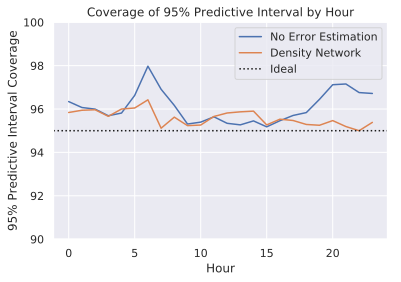

In [43]:
# Plot coverage as a fn of time of day
plt.plot(covs1, label='No Error Estimation')
plt.plot(covs2, label='Density Network')
plt.axhline(95.0, label='Ideal', ls=':', color='k')
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.ylim([90, 100])
plt.legend()
plt.show()

TODO: and we can also look at the coverage across pickup location

Text(0.5, 1.0, 'No Error Estimation')

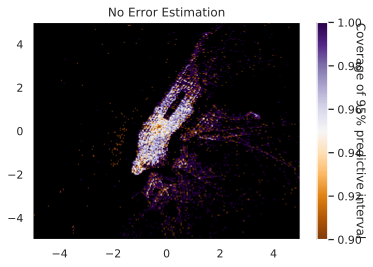

In [44]:
# Create vaex df with predictive intervals
cov_by_loc = pd.DataFrame()
cov_by_loc['x'] = x_data[:, 0].numpy()
cov_by_loc['y'] = x_data[:, 1].numpy()
cov_by_loc['covered'] = covered1
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
lims = [[-5, 5],[-5, 5]]
cov = vdf.mean(vdf.covered, limits=lims, shape=250,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower', aspect='auto',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)
plt.title('No Error Estimation')

Text(0.5, 1.0, 'Density Network')

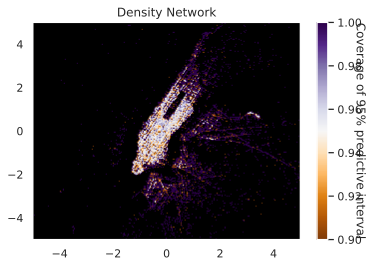

In [45]:
# Create vaex df with predictive intervals
cov_by_loc['covered'] = covered2
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
cov = vdf.mean(vdf.covered, limits=lims, shape=250,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
plt.imshow(cov.T, origin='lower', aspect='auto',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)
plt.title('Density Network')